# Decomposition code

In [1]:
import argparse
import dill
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pickle
import qiskit as qk
from qiskit.quantum_info import Operator, Statevector
from qiskit.circuit.quantumcircuit import QuantumCircuit
import time
import tqdm
from typing import Tuple

from akash.TFIM_ham_gen import construct_hamiltonian

import dreamcoder as dc
from dreamcoder.frontier import Frontier, FrontierEntry
from dreamcoder.fragmentGrammar import FragmentGrammar
from dreamcoder.grammar import Grammar
from dreamcoder.program import Program
from dreamcoder.program import Abstraction
from dreamcoder.task import Task
from dreamcoder.utilities import numberOfCPUs
import dreamcoder.domains.quantum_ground_state.primitives as pr
from dreamcoder.domains.quantum_ground_state.primitives import (
    circuit_to_mat,
    full_op_names,
    mat_contraction,
    mat_to_tensor,
    execute_program,
    normalize_unitary,
    get_qiskit_circuit,
    get_instructions_from_qiskit,
    get_code_from_instructions,
    qiskit_full_op_names,
    tcircuit,
    tensor_contraction,
    no_op,
    n_qubit_gate,
    QiskitTester,
)
from dreamcoder.domains.quantum_ground_state.primitives import execute_quantum_algorithm
from dreamcoder.domains.quantum_ground_state.tasks import GroundStateTask,get_energy
from dreamcoder.program import Program, Primitive, EtaLongVisitor
from dreamcoder.utilities import eprint, Curried

%load_ext line_profiler
%load_ext memory_profiler
%load_ext autoreload
%autoreload 2

In [2]:
decomposed_list = [0, 1]


class args:
    n_qubits = 2
    J = 1
    hh = 0.05
    decomposed = 1
    arity = 2
    structurePenalty = 1
    pseudoCounts = 10


# Read the command line arguments
parser = argparse.ArgumentParser(
    description="Example implementation of Regularized Mutual Information Feature Selector on a solid drop.",
    epilog="Results will be saved in files with the OUTPUT tag in the 'outputs/' folder.",
    formatter_class=argparse.ArgumentDefaultsHelpFormatter,
)

parser.add_argument(
    "-n_qubits", type=int, default=args.n_qubits, help="Number of qubits"
)
parser.add_argument("-J", type=float, default=args.J, help="Interaction strength")
parser.add_argument("-hh", type=float, default=args.hh, help="External field strength")
parser.add_argument(
    "-decomposed",
    type=int,
    default=args.decomposed,
    help="Either 0=parametrized gates, 1=qiskit hardware basis",
)
parser.add_argument(
    "-arity",
    type=int,
    default=args.arity,
    help="Number of arguments of extracted gates",
)
parser.add_argument(
    "-structurePenalty", type=int, default=args.structurePenalty, help="hyperparameter"
)
parser.add_argument(
    "-pseudoCounts", type=int, default=args.pseudoCounts, help="hyperparameter"
)

try:
    args = parser.parse_args()
except SystemExit as e:
    eprint("Running from interactive session. Loading default parameters")

usage: ipykernel_launcher.py [-h] [-n_qubits N_QUBITS] [-J J] [-hh HH]
                             [-decomposed DECOMPOSED] [-arity ARITY]
                             [-structurePenalty STRUCTUREPENALTY]
                             [-pseudoCounts PSEUDOCOUNTS]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/leopoldo/.local/share/jupyter/runtime/kernel-v3a9dc36f7c231c7be4f9c1bc636fe89461ae1be67.json
762002226.py:48 > Running from interactive session. Loading default parameters


In [3]:
path = f"akash/solved_RL_circuits/circ_list_TFIM_qubit{args.n_qubits}_J{args.J}_h{args.hh}_decomposed{args.decomposed}.pickle"
name = f"ground_{args.n_qubits}_J{args.J}_h{args.hh}_dec{args.decomposed}"
with open(path, "rb") as handle:
    b = dill.load(handle)
eprint(f"Loading solutions from {path}")

4151542144.py:5 > Loading solutions from akash/solved_RL_circuits/circ_list_TFIM_qubit2_J1_h0.05_decomposed1.pickle


In [4]:
# Unfortunately these flags are set globally
# TODO: remove
dc.domains.quantum_ground_state.primitives.GLOBAL_NQUBIT_TASK = args.n_qubits
dc.domains.quantum_ground_state.primitives.GLOBAL_LIMITED_CONNECTIVITY = False

library_settings = {
    "topK": 2,  # how many solutions to consider
    "arity": args.arity,  # how many arguments
    "structurePenalty": args.structurePenalty,  # increase regularization 3 4 (it was 1), look at a few in [1,15]
    "pseudoCounts": args.pseudoCounts,  # increase to 100, test a few values
}

primitives = [pr.p_sx, pr.p_x, pr.p_rz, pr.p_cz]
grammar = Grammar.uniform(primitives)
eprint(f"Library building settings: {library_settings}")

3188741822.py:15 > Library building settings: {'topK': 2, 'arity': 2, 'structurePenalty': 1, 'pseudoCounts': 10}


In [5]:
# Generate a few example tasks
solutions = {}  # dict of task:solution
# NOTE: we have a task for each decomposition because they have various different real parameters
# We cannot have solutions with different requests for a task,
# and it is not clear how to use real numbers as primitives (just for evaluation, we cannot enumerate them)
for idx, circuit in enumerate(b):
    H = construct_hamiltonian(args.J, args.hh, args.n_qubits)
    instructions = get_instructions_from_qiskit(circuit)
    code, arguments = get_code_from_instructions(instructions)
    program = Program.parse(code)
    task = GroundStateTask(
        f"J_{args.J:2.2f}_h_{args.hh:2.2f}_N_{args.n_qubits}_v{idx}",
        hamiltonian=H,
        arguments=arguments,
        request=program.infer(),
    )
    likelihood = task.logLikelihood(program)
    prior = grammar.logLikelihood(program.infer(), program)

    frontier_entry = FrontierEntry(
        program=program, logLikelihood=likelihood, logPrior=prior
    )

    solutions[task] = Frontier(
        frontier=[frontier_entry],  # multiple solutions are allowed
        task=task,
    )
    eprint(f"#{idx:3}, Energy = {likelihood:2.6f}")
tasks = list(solutions.keys())

3497839103.py:28 > #  0, Energy = 1.004986
3497839103.py:28 > #  1, Energy = 1.004986
3497839103.py:28 > #  2, Energy = 1.004985
3497839103.py:28 > #  3, Energy = 1.004980


3497839103.py:28 > #  4, Energy = 1.004979
3497839103.py:28 > #  5, Energy = 1.004979
3497839103.py:28 > #  6, Energy = 1.004979
3497839103.py:28 > #  7, Energy = 1.004978
3497839103.py:28 > #  8, Energy = 1.004934
3497839103.py:28 > #  9, Energy = 1.004932
3497839103.py:28 > # 10, Energy = 1.004931
3497839103.py:28 > # 11, Energy = 1.004930
3497839103.py:28 > # 12, Energy = 1.004929
3497839103.py:28 > # 13, Energy = 1.004929
3497839103.py:28 > # 14, Energy = 1.004929
3497839103.py:28 > # 15, Energy = 1.004925
3497839103.py:28 > # 16, Energy = 1.004898
3497839103.py:28 > # 17, Energy = 1.004894
3497839103.py:28 > # 18, Energy = 1.004872
3497839103.py:28 > # 19, Energy = 1.004745
3497839103.py:28 > # 20, Energy = 1.004743
3497839103.py:28 > # 21, Energy = 1.004743
3497839103.py:28 > # 22, Energy = 1.004743
3497839103.py:28 > # 23, Energy = 1.004685
3497839103.py:28 > # 24, Energy = 1.004554
3497839103.py:28 > # 25, Energy = 1.004543
3497839103.py:28 > # 26, Energy = 1.004542
3497839103.

In [6]:
frontiers = [f for f in solutions.values()]

unique_frontiers_set = set()
unique_frontiers = []
for frontier in frontiers:
    program = frontier.entries[0].program
    if program not in unique_frontiers_set:
        unique_frontiers_set.add(program)
        unique_frontiers.append(frontier)
eprint(
    f"We have {len(unique_frontiers)}/{len(frontiers)} frontiers. The others are duplicate solutions"
)

unique_frontiers

1863397296.py:10 > We have 26/28 frontiers. The others are duplicate solutions


[Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (x (x (cz (sx (rz (sx (cz (x (sx (sx (cz (sx (cz (sx (cz (x (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $1) $1 $2) $1) $1 $2) $1) $1 $2) $1) $2) $2) $1 $2) $1) $3 $2) $2) $1 $2) $1) $2))))), logPrior=-53.42946076810878, logLikelihood=1.0049859541843977], task=J_1.00_h_0.05_N_2_v0),
 Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (cz (cz (rz (cz (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $5 $2) $4 $1) $1) $1 $2) $2) $1 $2) $3 $1) $1 $2) $1 $2))))))), logPrior=-39.91405480259485, logLikelihood=1.0049857375304754], task=J_1.00_h_0.05_N_2_v1),
 Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (cz (rz (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $5 $2) $4 $1) $1) $1 $2) $2) $3 $2) $1 $2))))))), logPrior=-33.92259025548687, logLikelihood=1.0049847779142502], task=J_1.00_h_0.05_N_2_v2),
 Frontier(entries=[Fronti

In [15]:
# Run library decomposition
start = time.time()
new_grammar, new_frontiers = FragmentGrammar.induceFromFrontiers(
    g0=grammar,
    frontiers=unique_frontiers[-2:],
    **library_settings,
    CPUs=4#1#numberOfCPUs() - 2
)
end = time.time()
delta = end-start
eprint(f"Completed gate extraction in {delta} seconds.")
new_grammar, new_frontiers

fragmentGrammar.py:310 > Inducing a grammar from 2 frontiers


fragmentGrammar.py:336 > Starting score -70.6851296154324
fragmentGrammar.py:344 > Proposed 8772 fragments.
fragmentGrammar.py:365 > New primitive of type tcircuit	(sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $3 $2) $4 $1) $1) $1 $2) $2)	
(score = -39.93979223376414; dScore = 30.745337381668264; <uses> = 1.999999999944439)
fragmentGrammar.py:373 > 	(<uses> in rewritten frontiers: 2.0)
fragmentGrammar.py:336 > Starting score -39.93979223376414
fragmentGrammar.py:344 > Proposed 4 fragments.
fragmentGrammar.py:389 > Old joint = -61.6239680817188	New joint = -20.799792233569512

fragmentGrammar.py:401 > 0.0 / 7.0	sx
fragmentGrammar.py:401 > 0.0 / 7.0	x
fragmentGrammar.py:401 > 1.0 / 7.0	rz
fragmentGrammar.py:401 > 2.0 / 7.0	cz
fragmentGrammar.py:401 > 2.0 / 7.0	#(lambda (lambda (lambda (lambda (lambda (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $3 $2) $4 $1) $1) $1 $2) $2))))))
3668640334.py:11 > Completed gate extraction in 24.259639501571655 seconds.


(<dreamcoder.grammar.Grammar at 0x7f0caa222090>,
 [Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (cz (#(lambda (lambda (lambda (lambda (lambda (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $3 $2) $4 $1) $1) $1 $2) $2)))))) $3 $4 $2 $1 $0) $1 $2)))))), logPrior=-9.136361471040571, logLikelihood=1.0045424277279942], task=J_1.00_h_0.05_N_2_v26),
  Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (cz (rz (#(lambda (lambda (lambda (lambda (lambda (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $3 $2) $4 $1) $1) $1 $2) $2)))))) $4 $5 $2 $1 $0) $3 $1) $1 $2))))))), logPrior=-13.672515594155547, logLikelihood=1.0045424036484267], task=J_1.00_h_0.05_N_2_v27)])

In [21]:
# Save results
timestamp = datetime.now().isoformat()
with open(f"experimentOutputs/{timestamp}_{name}_grammar.pickle", "wb") as f:
    pickle.dump(new_grammar, f)

with open(f"experimentOutputs/{timestamp}_{name}_frontiers.pickle", "wb") as f:
    pickle.dump(new_frontiers, f)
eprint(f"Results saved in experimentOutputs/{timestamp}_{name}_...")

69069040.py:7 > Results saved in experimentOutputs/2024-09-17T19:03:39.955420_ground_2_J1_h0.05_dec1_...


---

# Some analysis

In [120]:
path = "experimentOutputs/2024-09-17T19:03:39.955420_ground_2_J1_h0.05_dec1_"
path = "experimentOutputs/2024-09-24T19:36:36.727156_ground_2_J1_h0.05_dec1_"
with open(f"{path}grammar.pickle", "rb") as f:
    new_grammar = pickle.load(f)

with open(f"{path}frontiers.pickle", "rb") as f:
    new_frontiers = pickle.load(f)

In [156]:
name = {}
simplification = {}
depth = {}


# The following are auxiliary functions to handle invented primitives
def get_program_children(program):
    try:
        return {k: getName(k) for _, k in program.body.walk() if k.isInvented}
    except:
        return {k: getName(k) for _, k in program.walk() if k.isInvented}


def get_program_simplification(program):
    if program in name:
        return name[program]
    children = get_program_children(program)
    simplification_ = program
    for k, childName in children.items():
        simplification_ = simplification_.substitute(
            k, Primitive(childName, ty=None, value=None)
        )
    return simplification_


def getName(program):
    if program in name:
        return name[program]
    children = get_program_children(program)
    simplification_ = get_program_simplification(program.body)
    # for original, simplified in nameSimplification.items():
    #     simplification_ = simplification_.substitute(Primitive(original,None,None),
    #                                                     Primitive(simplified,None,None))
    name[program] = "f%d" % len(name)
    # name[program] = f"f{len(name):03d}" # need to make name unambigous (f1 and f13 is not nice for easy string replacement)

    simplification[program] = simplification_
    depth[program] = 1 + max([depth[k] for k in children] + [0])
    return name[program]


def get_primitive_arguments(tp, arguments, last_qubit=0):
    # Get argument to run a primitive
    if len(tp.arguments) != 0:
        if tp.arguments[0].name == "int":
            arguments.append(last_qubit)
            last_qubit += 1
        elif tp.arguments[0].name == "real":
            arguments.append(0.0)  # TODO: change
        elif tp.arguments[0].name == "tcircuit":
            arguments.append(["no_op"])
        return get_primitive_arguments(tp.arguments[1], arguments, last_qubit)

    else:  # TODO: why is this function getting called in two different ways?
        for i in range(len(arguments)):
            if type(arguments[i]) == list:
                arguments[i] = no_op(last_qubit)
        return arguments


def get_primitive_lambda(n_qubit, operation_name):
    return lambda old_circuit, *q: n_qubit_gate(
        old_circuit, *q, operation_name=operation_name
    )


# def get_qk_lambda(n_qubit, gate):
#     return lambda QT, *q: QT.circuit.append(gate, (QT.q(qq) for qq in q))

def get_qk_lambda(QT, arguments, program, name, tp):
    # arguments = get_primitive_arguments(tp, arguments=arguments)
    qubits = list(filter(lambda x:type(x)==int, arguments))
    n_qubits = max(qubits)+1
    
    # add identity circuit placeholder
    if len(list(filter(lambda x: type(x)==tuple,arguments)))==0:
        tps,i = tp.arguments,0
        while len(tps)>1:
            if tps[0].name=="tcircuit":
                arguments = arguments[:i] + (no_op(n_qubits),) + arguments[i:]
            tps,i=tps[1].arguments, i+1

    simplified_circuit = execute_program(program, arguments)
    qk_circuit = get_qiskit_circuit(simplified_circuit).circuit
    qk_circuit.name = name
    QT.circuit.append(qk_circuit, tuple(set(QT.q(qubit) for qubit in qubits)))
    # QT.circuit = QT.circuit.compose(qk_circuit.to_gate(), (QT.q(qq) for qq in arguments if type(qq) == int) )
    
def f_circuit(circuit_unitary, *arguments, circuit_template):
    # eprint(circuit_template)
    n_args, circuit_ops = circuit_template
    circuit_ops = list(circuit_ops)
    qubit = list(filter(lambda x:type(x)==int,arguments))
    # apply template to a given unitary matrix
    # returns a tuple of circuit ops ( ("gate", 1, 2, ...), ...   )

    # Invert qubit order only for int arguments (qubits)
    operations = []
    for op in circuit_ops:
        arguments = (qubit[q] if type(q) == int else q for q in op[1:])
        operations.append((op[0], *arguments))

    for op in operations:
        circuit_unitary = full_op_names[op[0]](circuit_unitary, *op[1:])
    return circuit_unitary

In [157]:
invented_primitives = [p for p in new_grammar.primitives if p.isInvented]
for p in invented_primitives:
    getName(p)
depths = {depth[p] for p in invented_primitives}
depth2primitives = {
    d: {p for p in invented_primitives if depth[p] == d} for d in depths
}

# Define primitive circuit operations as globals
for i, (original, simplified) in enumerate(list(simplification.items())):
    arguments = get_primitive_arguments(original.tp, [])
    n_arguments = len(arguments)
    n_qubits = max(filter(lambda x : type(x)==int,arguments))+1

    Primitive.GLOBALS[name[original]] = Primitive(
        name=name[original],
        ty=original.tp,
        value=Curried(
            get_primitive_lambda(n_arguments - 1, name[original]), arity=n_arguments
        ),
    )
    program = Program.parse(str(original))
    circuit = execute_program(program, arguments)

    # TODO: full_op_names should be fixed along with f_circuit
    full_op_names[name[original]] = (
        lambda tensor, *qubit, circuit_template=circuit: f_circuit(
            tensor, *qubit, circuit_template=circuit_template
        )
    )

    simplified_program = Program.parse(str(simplified))
    arguments = get_primitive_arguments(original.tp, [])

    # TODO: use functools.partials instead
    qiskit_full_op_names[name[original]] = (
        lambda QT, *arguments, program=simplified_program, name=name[
            original
        ], tp=original.tp: get_qk_lambda(QT, arguments, program, name, tp)
    )
    
    arguments = get_primitive_arguments(original.tp, [])
    QT = QiskitTester(n_qubits=n_qubits)
    qiskit_full_op_names[name[original]](QT, *arguments)
    eta_long = EtaLongVisitor().execute(simplified_program)
    print(f"{name[original]}: {eta_long}")  # EtaLong for a better program string
    print("Simplified circuit")
    print(QT.circuit.decompose().draw())
    print("Expanded circuit")
    print(get_qiskit_circuit(circuit).circuit)

f0: (lambda (lambda (lambda (lambda (lambda (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $3 $2) $4 $1) $1))))))
Simplified circuit
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├───────────────
     └───┘ └────┘└───────┘               
Expanded circuit
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├───────────────
     └───┘ └────┘└───────┘               
f1: (lambda (lambda (lambda (lambda (lambda (lambda (cz (rz (x (sx (sx (cz (rz (rz $0 $1 $2) $3 $4) $2 $4) $2) $4) $2) $5 $2) $2 $4)))))))
Simplified circuit
     ┌───────┐   ┌────┐┌───┐┌───────┐   
q_0: ┤ Rz(0) ├─■─┤ √X ├┤ X ├┤ Rz(0) ├─■─
     ├───────┤ │ ├────┤└───┘└───────┘ │ 
q_1: ┤ Rz(0) ├─■─┤ √X ├───────────────■─
     └───────┘   └────┘                 
Expanded circuit
     ┌───────┐   ┌────┐┌───┐┌───────┐   
q_0

primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 2 does not match the instruction expectation (3).'


f8: (lambda (lambda (lambda (lambda (lambda (lambda (lambda (f4 $0 $1 (f4 $0 $2 (f4 $3 $4 $5 $6 $0) $6 $0) $6 $0))))))))
Simplified circuit
     
q_0: 
     
q_1: 
     
q_2: 
     
Expanded circuit
                 ┌───────┐   ┌───────┐   
q_0: ──────────■─┤ Rz(0) ├─■─┤ Rz(0) ├─■─
     ┌───────┐ │ └───────┘ │ └───────┘ │ 
q_1: ┤ Rz(0) ├─┼───────────┼───────────┼─
     └───────┘ │           │           │ 
q_2: ──────────■───────────■───────────■─
                                         
f9: (lambda (lambda (lambda (lambda (lambda (f4 $0 $1 (rz $2 $3 $4) $4 $0))))))
Simplified circuit
              ┌─────┐
q_0: ─────────┤0    ├
     ┌───────┐│  f4 │
q_1: ┤ Rz(0) ├┤1    ├
     └───────┘└─────┘
Expanded circuit
     ┌───────┐   
q_0: ┤ Rz(0) ├─■─
     ├───────┤ │ 
q_1: ┤ Rz(0) ├─■─
     └───────┘   


primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 2 does not match the instruction expectation (3).'


f10: (lambda (lambda (lambda (lambda (lambda (f4 $0 $1 (x (cz (sx (sx $2 $3) $0) $3 $0) $4) $3 $0))))))
Simplified circuit
     
q_0: 
     
q_1: 
     
q_2: 
     
Expanded circuit
     ┌────┐   ┌───────┐   
q_0: ┤ √X ├─■─┤ Rz(0) ├─■─
     ├────┤ │ └───────┘ │ 
q_1: ┤ √X ├─■───────────■─
     ├───┬┘               
q_2: ┤ X ├────────────────
     └───┘                
f11: (lambda (lambda (lambda (sx (rz $0 $1 $2) $2))))
Simplified circuit
   ┌───────┐┌────┐
q: ┤ Rz(0) ├┤ √X ├
   └───────┘└────┘
Expanded circuit
   ┌───────┐┌────┐
q: ┤ Rz(0) ├┤ √X ├
   └───────┘└────┘
f12: (lambda (lambda (lambda (lambda (lambda (f4 $0 $1 (f4 $0 $2 (cz $3 $0 $4) $0 $4) $0 $4))))))
Simplified circuit
        ┌─────┐┌─────┐
q_0: ─■─┤0    ├┤0    ├
      │ │  f4 ││  f4 │
q_1: ─■─┤1    ├┤1    ├
        └─────┘└─────┘
Expanded circuit
        ┌───────┐   ┌───────┐   
q_0: ─■─┤ Rz(0) ├─■─┤ Rz(0) ├─■─
      │ └───────┘ │ └───────┘ │ 
q_1: ─■───────────■───────────■─
                                
f13: (lambd

In [158]:
solved_tasks = []
for idx, f in enumerate(new_frontiers):
    task = f.task
    print(f"---------------------------------------")
    print(f"Task {task.name}")

    solved = f.entries[0]
    program = solved.program
    simplified_program = get_program_simplification(program)
    # reparse to update primitive functions
    simplified_program = dc.program.Program.parse(str(simplified_program))
    arguments = get_primitive_arguments(program.infer(),[])

    circuit = execute_program(program, arguments)
    reconstructed_circuit = get_qiskit_circuit(circuit)
    print(reconstructed_circuit.circuit)

    simplified_circuit = execute_program(simplified_program, arguments)
    simplified_reconstructed_circuit = get_qiskit_circuit(simplified_circuit)
    print(simplified_reconstructed_circuit.circuit)

    c_depth = len(execute_program(program, arguments)[1])
    solved_tasks.append([solved.logLikelihood, reconstructed_circuit.circuit, simplified_reconstructed_circuit.circuit, c_depth])


---------------------------------------
Task J_1.00_h_0.05_N_2_v0
     ┌────┐┌───┐ ┌────┐┌───┐   ┌────┐   ┌────┐   ┌────┐          ┌────┐       »
q_0: ┤ √X ├┤ X ├─┤ √X ├┤ X ├─■─┤ √X ├─■─┤ √X ├─■─┤ √X ├──────■───┤ √X ├───────»
     ├───┬┘├───┴┐└────┘└───┘ │ └────┘ │ └────┘ │ ├────┤┌───┐ │ ┌─┴────┴┐┌────┐»
q_1: ┤ X ├─┤ √X ├────────────■────────■────────■─┤ √X ├┤ X ├─■─┤ Rz(0) ├┤ √X ├»
     └───┘ └────┘                                └────┘└───┘   └───────┘└────┘»
«        ┌───┐
«q_0: ─■─┤ X ├
«      │ ├───┤
«q_1: ─■─┤ X ├
«        └───┘


primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 1 does not match the instruction expectation (2).'


     
q_0: 
     
q_1: 
     
---------------------------------------
Task J_1.00_h_0.05_N_2_v1
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐            ┌───────┐      
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├─■────────■─┤ Rz(0) ├─■──■─
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘ │ ┌────┐ │ └───────┘ │  │ 
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├────────────────■─┤ √X ├─■───────────■──■─
     └───┘ └────┘└───────┘                  └────┘                  
     ┌──────┐┌─────┐   
q_0: ┤0     ├┤0    ├─■─
     │  f15 ││  f4 │ │ 
q_1: ┤1     ├┤1    ├─■─
     └──────┘└─────┘   
---------------------------------------
Task J_1.00_h_0.05_N_2_v2
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐                     
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├─■─────────────────■─
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘ │ ┌────┐┌───────┐ │ 
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├────────────────■─┤ √X ├┤ Rz(0) ├─■─
     └───┘ └────┘└───────┘                  └────┘└───────┘   
     ┌──────┐
q_0: ┤0     ├
     │  f18 │
q_1: ┤1     ├
  

primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 1 does not match the instruction expectation (2).'


     
q_0: 
     
q_1: 
     
---------------------------------------
Task J_1.00_h_0.05_N_2_v8
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐┌───────┐                     
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├┤ Rz(0) ├─■─────────────────■─
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘└───────┘ │ ┌───────┐┌────┐ │ 
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├─────────────────────────■─┤ Rz(0) ├┤ √X ├─■─
     └───┘ └────┘└───────┘                           └───────┘└────┘   
     ┌─────┐┌─────┐┌──────┐
q_0: ┤0    ├┤0    ├┤0     ├
     │  f0 ││  f4 ││  f19 │
q_1: ┤1    ├┤1    ├┤1     ├
     └─────┘└─────┘└──────┘
---------------------------------------
Task J_1.00_h_0.05_N_2_v9
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐   ┌───────┐                        »
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├─■─┤ Rz(0) ├──────────■───────────■─»
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘ │ └─┬────┬┘┌───────┐ │ ┌───────┐ │ »
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├────────────────■───┤ √X ├─┤ Rz(0) ├─■─┤ Rz(0) ├─■─»
     └───┘ └────┘└────

primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 1 does not match the instruction expectation (2).'


     
q_0: 
     
q_1: 
     
---------------------------------------
Task J_1.00_h_0.05_N_2_v15
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐   ┌───────┐            
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├─■─┤ Rz(0) ├──────────■─
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘ │ └─┬────┬┘┌───────┐ │ 
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├────────────────■───┤ √X ├─┤ Rz(0) ├─■─
     └───┘ └────┘└───────┘                    └────┘ └───────┘   
     ┌─────┐┌─────┐
q_0: ┤0    ├┤0    ├
     │  f3 ││  f9 │
q_1: ┤1    ├┤1    ├
     └─────┘└─────┘
---------------------------------------
Task J_1.00_h_0.05_N_2_v16
     ┌───────┐   ┌────┐┌───┐┌───────┐   ┌───────┐┌────┐   ┌───────┐   ┌───────┐»
q_0: ┤ Rz(0) ├─■─┤ √X ├┤ X ├┤ Rz(0) ├─■─┤ Rz(0) ├┤ √X ├─■─┤ Rz(0) ├─■─┤ Rz(0) ├»
     ├───────┤ │ ├────┤└───┘└───────┘ │ └───────┘└────┘ │ └───────┘ │ └───────┘»
q_1: ┤ Rz(0) ├─■─┤ √X ├───────────────■─────────────────■───────────■──────────»
     └───────┘   └────┘                                                        »
«

primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 1 does not match the instruction expectation (2).'


     
q_0: 
     
q_1: 
     
---------------------------------------
Task J_1.00_h_0.05_N_2_v17
          ┌───┐  ┌────┐     ┌───┐                 ┌───────┐                  
q_0: ─■───┤ X ├──┤ √X ├─■───┤ X ├───■───────────■─┤ Rz(0) ├────────────────■─
      │ ┌─┴───┴─┐├────┤ │ ┌─┴───┴─┐ │ ┌───────┐ │ ├───────┤┌────┐┌───────┐ │ 
q_1: ─■─┤ Rz(0) ├┤ √X ├─■─┤ Rz(0) ├─■─┤ Rz(0) ├─■─┤ Rz(0) ├┤ √X ├┤ Rz(0) ├─■─
        └───────┘└────┘   └───────┘   └───────┘   └───────┘└────┘└───────┘   
          ┌───┐  ┌──────┐┌─────┐┌───────┐┌──────┐
q_0: ─■───┤ X ├──┤0     ├┤0    ├┤ Rz(0) ├┤0     ├
      │ ┌─┴───┴─┐│  f10 ││  f4 │└───────┘│  f20 │
q_1: ─■─┤ Rz(0) ├┤1     ├┤1    ├─────────┤1     ├
        └───────┘└──────┘└─────┘         └──────┘
---------------------------------------
Task J_1.00_h_0.05_N_2_v18
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐            ┌───────┐      
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├─■────────■─┤ Rz(0) ├─■──■─
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘ │ ┌────┐ │ ├────

primitives.py:804 > invalid quantum circuit! 'The amount of qubit arguments 1 does not match the instruction expectation (2).'


     ┌─────┐┌────┐┌──────┐
q_0: ┤0    ├┤ √X ├┤0     ├
     │  f1 │├────┤│  f20 │
q_1: ┤1    ├┤ √X ├┤1     ├
     └─────┘└────┘└──────┘
---------------------------------------
Task J_1.00_h_0.05_N_2_v20
     ┌────┐┌───┐   ┌────┐ ┌───────┐┌────┐   ┌───────┐  ┌───┐                   »
q_0: ┤ √X ├┤ X ├───┤ √X ├─┤ Rz(0) ├┤ √X ├─■─┤ Rz(0) ├──┤ X ├─────────────────■─»
     ├───┬┘├───┴┐┌─┴────┴┐└───────┘└────┘ │ └─┬────┬┘┌─┴───┴─┐┌───┐┌───────┐ │ »
q_1: ┤ X ├─┤ √X ├┤ Rz(0) ├────────────────■───┤ √X ├─┤ Rz(0) ├┤ X ├┤ Rz(0) ├─■─»
     └───┘ └────┘└───────┘                    └────┘ └───────┘└───┘└───────┘   »
«                             
«q_0: ──────────■───────────■─
«     ┌───────┐ │ ┌───────┐ │ 
«q_1: ┤ Rz(0) ├─■─┤ Rz(0) ├─■─
«     └───────┘   └───────┘   
     ┌─────┐┌───────┐┌───┐┌─────┐
q_0: ┤0    ├┤ Rz(0) ├┤ X ├┤0    ├
     │  f3 │├───────┤├───┤│  f8 │
q_1: ┤1    ├┤ Rz(0) ├┤ X ├┤1    ├
     └─────┘└───────┘└───┘└─────┘
---------------------------------------
Task J_1.00_h_0.05_N_2_v21
 

In [159]:
sorted_circuits = sorted(solved_tasks,key=lambda x:x[0])

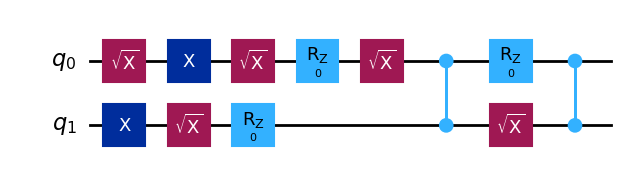

In [160]:
sorted_circuits[0][1].draw("mpl")

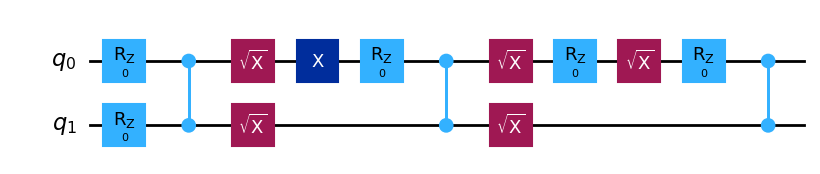

In [161]:
sorted_circuits[7][1].draw("mpl")

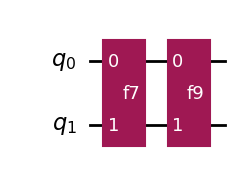

In [131]:
solved_tasks[3][2].draw("mpl")


(cz ($0 (cz ($0 (cz ($0 (cz ($0 (cz ($0 (cz ($0 (cz ($0 (x ($0 (x ($0 (x ($0 (x (cz ($0 ($0 (cz ($0 ($0 (x (x $1 $2) $3) $4 $2) $5 $3) $2 $3) $6 $2) $7 $3) $2 $3) $2) $8 $3) $3) $9 $2) $2) $10 $3) $3) $11 $2) $2 $3) $12 $2) $2 $3) $13 $3) $2 $3) $14 $2) $2 $3) $15 $3) $2 $3) $16 $3) $2 $3) $17 $2) $2 $3)	


In [8]:
path

'akash/solved_RL_circuits/circ_list_TFIM_qubit2_J1_h0.001_decomposed1.pickle'

In [33]:
frontiers

[Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (sx (x (sx (cz (sx (rz (cz (rz (x (sx (rz (sx $0 $2) $5 $1) $1) $2) $4 $2) $1 $2) $3 $2) $2) $1 $2) $1) $2) $2))))))), logPrior=-33.92259025548687, logLikelihood=1.0000019905250335], task=J_1.00_h_0.00_N_2_v0),
 Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (lambda (lambda (lambda (lambda (sx (cz (x (x (sx (sx (rz (x (rz (x (rz (sx (cz (x (rz (sx (cz (rz (cz (rz (x (cz (sx (rz (x $0 $2) $9 $1) $2) $1 $2) $2) $8 $1) $1 $2) $7 $2) $1 $2) $2) $6 $1) $1) $1 $2) $1) $5 $2) $2) $4 $1) $1) $3 $2) $1) $2) $1) $2) $1 $2) $2))))))))))), logPrior=-76.26117218347213, logLikelihood=1.0000019905250335], task=J_1.00_h_0.00_N_2_v1),
 Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (x (sx (x (sx (x (rz (sx (rz (x (sx (sx (cz (x (cz (sx $0 $1) $1 $2) $1) $1 $2) $1) $2) $1) $4 $2) $2) $3 $1) $1) $1) $1) $1) $1)))))), logPrior=-38.92080302958456

In [163]:
instructions = get_instructions_from_qiskit(circuit)
code, arguments = get_code_from_instructions(instructions)
program = Program.parse(code)
reconstructed = execute_program(program, arguments)

# Test

In [ ]:
# psi0 = np.array([1,0,0,0])
# rot = np.array(Operator(circ).data)
# psi1= np.dot(rot,psi0)

In [ ]:
# pipeline is
# CODE:str --> PROGRAM:Program --> INSTRUCTIONS:tuple --> CIRCUIT: QuantumCircuit

# inverse pipeline is
# CIRCUIT: QuantumCircuit --> INSTRUCTIONS: tuple --> CODE: str

In [ ]:
H = construct_hamiltonian(J, h, n_qubits)
for circ in b:
    psi0 = Statevector.from_int(0, 2**n_qubits)
    psi1 = psi0.evolve(circ)
    print(get_energy(psi1.data, H))

instructions = get_instructions_from_qiskit(circ)
code, arguments = get_code_from_instructions(instructions)
program = Program.parse(code)

(-1.0000019905250335+0j)
(-1.000000389117297-5.551115123125783e-17j)
(-1.0000001942192795+0j)
(-1.0000000807637257+0j)
(-1.0000000793832347-5.551115123125783e-17j)
(-1.0000000000000002+0j)
(-1.0000000000000004+0j)
(-1.0000000000000004+0j)
(-1.0000000000000004+0j)
(-1.0000000000000004+0j)
(-1.0000000000000004+0j)
(-1.0000000000000004+0j)
(-1.0000000000000004+0j)
(-0.9999999999999998+0j)
(-0.9999999999999998+0j)
(-0.9999999999999998+0j)
(-0.9999999999999998+0j)
(-0.9999999999999998+0j)
(-0.9999999999999998+0j)
(-0.9999999999999998+0j)


In [ ]:
# Test: get_qiskit_circuit(instructions) --> same circuit
instructions = get_instructions_from_qiskit(circ)
reconstructed_circuit = get_qiskit_circuit(instructions)
Operator(reconstructed_circuit.circuit).data - Operator(circ).data

In [ ]:
# Test: get code from instructions
code, arguments = get_code_from_instructions(instructions)
program = Program.parse(code)
reconstructed = execute_program(program, arguments)
reconstructed == instructions

print(program)
print(reconstructed)
print(instructions)

In [16]:
primitives

[sx, x, rz, cz]

In [21]:
# Test: unitary from instructions
with QiskitTester(2) as QT:
    QT.circuit.rz(1, 1)
QT.circuit.draw()
instructions = get_instructions_from_qiskit(QT.circuit)
Operator(QT.circuit).data, circuit_to_mat(instructions)

(array([[0.87758256-0.47942554j, 0.        +0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.87758256-0.47942554j,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.87758256+0.47942554j, 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.        +0.j        , 0.87758256+0.47942554j]]),
 array([[0.87758256-0.47942554j, 0.        +0.j        ,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.87758256-0.47942554j,
         0.        +0.j        , 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.87758256+0.47942554j, 0.        +0.j        ],
        [0.        +0.j        , 0.        +0.j        ,
         0.        +0.j        , 0.87758256+0.47942554j]]))

In [ ]:
instructions = (2, (("sxdg", 0), ("x", 0), ("x", 1), ("rz", 1.43, 1), ("cnot", 0, 1)))
get_qiskit_circuit(instructions).circuit.draw()
# with QiskitTester(circuit=instructions) as QT:
#     QT.circuit.sxdg(QT.q(0))
# QT.circuit.draw()

┌───┐  ┌──────────┐┌───┐
q_0: ─┤ X ├──┤ Rz(1.43) ├┤ X ├
     ┌┴───┴─┐└──┬───┬───┘└─┬─┘
q_1: ┤ √Xdg ├───┤ X ├──────■──
     └──────┘   └───┘

In [ ]:
instructions = (
    1,
    (
        # ("sxdg", 0),
        # ("x", 0),
        # ("x", 1),
        ("rz", 1.43, 0),
        # ("cnot", 0,1)
    ),
)
get_qiskit_circuit(instructions).circuit.draw()
code, arguments = get_code_from_instructions(instructions)

In [ ]:
code = "(lambda (lambda(lambda (rz $0 $2 $1 ) )))"
code = "(cnot (no_op(2)) 1 0)"
code = "(cnot (I 2) 0 1)"
code = "(x (I 1) 0 )"
code = "(x (rz (I 1) 11 0) 0 )"

In [ ]:
program = Program.parse(code)
instructions = execute_program(program, ())
get_qiskit_circuit(instructions).circuit.draw()

Exception: Attempt to evaluate hole

In [ ]:
for circ in b:
    H = construct_hamiltonian(J, h, n_qubits)
    instructions = get_instructions_from_qiskit(circ)
    code, arguments = get_code_from_instructions(instructions)
    program = Program.parse(code)
    task = GroundStateTask(
        f"J_{J:2.2f}_h_{h:2.2f}_N_{n_qubits}",
        hamiltonian=H,
        arguments=arguments,
        request=program.infer(),
    )
    energy = task.logLikelihood(program)

    psi0 = Statevector.from_int(0, 4)
    psi1 = psi0.evolve(circ)
    print(get_energy(psi1, H), energy)

(-1.0000019905250335+0j) 1.0000019905250335
(-1.000000389117297-5.551115123125783e-17j) 1.0000003891172966
(-1.0000001942192795+0j) 1.0000001942192795
(-1.0000000807637257+0j) 1.0000000807637257
(-1.0000000793832347-5.551115123125783e-17j) 1.000000079383235
(-1.0000000000000002+0j) 1.000000000000001
(-1.0000000000000004+0j) 1.0000000000000009
(-1.0000000000000004+0j) 1.0000000000000009
(-1.0000000000000004+0j) 1.0000000000000009
(-1.0000000000000004+0j) 1.0000000000000009
(-1.0000000000000004+0j) 1.0000000000000009
(-1.0000000000000004+0j) 1.0000000000000009
(-1.0000000000000004+0j) 1.0000000000000009
(-0.9999999999999998+0j) 1.0000000000000007
(-0.9999999999999998+0j) 1.0000000000000007
(-0.9999999999999998+0j) 1.0000000000000007
(-0.9999999999999998+0j) 1.0000000000000007
(-0.9999999999999998+0j) 1.0000000000000007
(-0.9999999999999998+0j) 1.0000000000000007
(-0.9999999999999998+0j) 1.0000000000000007


In [ ]:
instructions

(2,
 (('x', 0),
  ('rz', 12.852044105529785, 1),
  ('sx', 0),
  ('rz', 4.629762649536133, 0),
  ('cz', 1, 0),
  ('rz', 5.277709484100342, 1),
  ('cz', 1, 0),
  ('sx', 0),
  ('rz', 0.030434206128120422, 1),
  ('x', 1),
  ('x', 0),
  ('rz', -1.6001750230789185, 1),
  ('x', 1),
  ('cz', 1, 0),
  ('x', 1),
  ('x', 0),
  ('cz', 1, 0),
  ('rz', -0.9125978946685791, 1),
  ('cz', 1, 0),
  ('sx', 0),
  ('x', 1),
  ('rz', -1.3367031812667847, 1),
  ('rz', -1.1753524541854858, 0),
  ('x', 1),
  ('cz', 1, 0),
  ('sx', 1),
  ('x', 0),
  ('cz', 1, 0),
  ('sx', 1)))

# Profiling

In [10]:
import dill

class args:
    n_qubits = 2
    J = 1
    hh = 0.05
    decomposed = 1
    arity = 2
    structurePenalty = 1
    pseudoCounts = 10

library_settings = {
    "topK": 2,  # how many solutions to consider
    "arity": args.arity,  # how many arguments
    "structurePenalty": args.structurePenalty,  # increase regularization 3 4 (it was 1), look at a few in [1,15]
    "pseudoCounts": args.pseudoCounts,  # increase to 100, test a few values
}

In [11]:
len(unique_frontiers)

26

In [26]:
import random
import traceback
from multiprocessing import Pool

NEGATIVEINFINITY = float('-inf')
POSITIVEINFINITY = float('inf')



def parallelMap(numberOfCPUs, f, *xs, chunksize=None, maxtasksperchild=None):
    if numberOfCPUs == 1: return list(map(f, *xs))

    n = len(xs[0])
    for x in xs: assert len(x) == n
    print(n, xs)
    # Batch size of jobs as they are sent to processes
    if chunksize is None:
        chunksize = max(1, n // (numberOfCPUs * 2))

    with Pool(numberOfCPUs, maxtasksperchild=maxtasksperchild) as pool:
        # ys = pool.map(parallelMapCallBack, range(n), chunksize=chunksize)
        ys = pool.map(f, xs[0], chunksize=chunksize )

    return ys


In [33]:
arity = 2
CPUs = 2

def fragment(frontier, a=arity): 
    return dc.fragmentUtilities._frontier_fragmenter(frontier,a)


def test(x):
    print(x)
    return x + 1
    
result = parallelMap(CPUs,fragment, unique_frontiers[:8])
result
# parallelMap(2, test, [1,5,7, 8])

8 ([Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (x (x (cz (sx (rz (sx (cz (x (sx (sx (cz (sx (cz (sx (cz (x (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $1) $1 $2) $1) $1 $2) $1) $1 $2) $1) $2) $2) $1 $2) $1) $3 $2) $2) $1 $2) $1) $2))))), logPrior=-53.42946076810878, logLikelihood=1.0049859541843977], task=J_1.00_h_0.05_N_2_v0), Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (cz (cz (rz (cz (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $5 $2) $4 $1) $1) $1 $2) $2) $1 $2) $3 $1) $1 $2) $1 $2))))))), logPrior=-39.91405480259485, logLikelihood=1.0049857375304754], task=J_1.00_h_0.05_N_2_v1), Frontier(entries=[FrontierEntry(program=(lambda (lambda (lambda (lambda (lambda (lambda (cz (rz (sx (cz (sx (rz (rz (sx (x (sx (x (sx $0 $1) $2) $2) $1) $1) $5 $2) $4 $1) $1) $1 $2) $2) $3 $2) $1 $2))))))), logPrior=-33.92259025548687, logLikelihood=1.0049847779142502], task=J_1.00_h_0.05_N_2_v2), Frontier(entries=[Fronti

: 

In [1]:
from multiprocessing import Pool
from os import getpid

def double(i):
    print("I'm process", getpid())
    return i * 2

if __name__ == '__main__':
    with Pool() as pool:
        result = pool.map(double, [1, 2, 3, 4, 5])
        print(result)

I'm processI'm processI'm processI'm processI'm process     16349661634965163496416349671634968




[2, 4, 6, 8, 10]


In [41]:
import gc
gc.collect()

0

In [8]:
arity = 2
CPUs = 1
proposedFragments = dc.fragmentUtilities.proposeFragmentsFromFrontiers(unique_frontiers,arity,CPUs)

In [9]:
arity = 2
CPUs = 2
proposedFragments = dc.fragmentUtilities.proposeFragmentsFromFrontiers(unique_frontiers,arity,CPUs)

KeyboardInterrupt: 

In [12]:
arity = 2
CPUs = 8
proposedFragments = dc.fragmentUtilities.proposeFragmentsFromFrontiers(unique_frontiers,arity,CPUs)

In [13]:
try:
    proposedFragments
    with open("experimentOutputs/proposed_dump","wb") as f:
        dill.dump(proposedFragments,f)
except Exception as e:
    eprint("Error:", e)
    ...

In [11]:
with open("experimentOutputs/proposed_dump","rb") as f:
    proposedFragments=dill.load(f)

EOFError: Ran out of input

In [6]:
proposedFragments[0]

(x (cz (sx $0 $1) $2 $3) $2)

In [ ]:
%mprun -f FragmentGrammar.induceFromFrontiers -f dc.fragmentUtilities.proposeFragmentsFromFrontiers FragmentGrammar.induceFromFrontiers(g0=grammar,frontiers=unique_frontiers[-3:],**library_settings,CPUs=1)

fragmentGrammar.py:295 > Inducing a grammar from 3 frontiers


fragmentGrammar.py:320 > Starting score -139.22097145497253


*** KeyboardInterrupt exception caught in code being profiled.


Filename: /home/leopoldo/notebooks/notebooks/unitary-synthesis/dreamcoder/fragmentGrammar.py

Line #    Mem usage    Increment  Occurrences   Line Contents
   280   2801.2 MiB   2801.2 MiB           1       @staticmethod
   281                                             def induceFromFrontiers(
   282                                                     g0:Grammar,
   283                                                     frontiers:List[FrontierEntry],
   284                                                     arity,
   285                                                     _=None,
   286                                                     topK=1,
   287                                                     topk_use_only_likelihood=False,
   288                                                     pseudoCounts=1.0,
   289                                                     aic=1.0,
   290                                                     structurePenalty=0.001,
   291                 

In [ ]:
import time, tqdm
times = []

for frontier in tqdm.tqdm(unique_frontiers):
    start = time.time()
    dc.fragmentGrammar.proposeFragmentsFromProgram(frontier.entries[0].program,2)
    end = time.time()
    delta = end-start
    times.append(delta)

100%|██████████| 26/26 [01:08<00:00,  2.64s/it]


In [21]:
fragments = []
for f in tqdm.tqdm(proposedFragments):
    if f not in grammar.primitives and dc.fragmentUtilities.defragment(f) not in grammar.primitives:
        fragments.append(f)
eprint(f"Proposed {len(fragments)} fragments." )

candidateGrammars = [
    FragmentGrammar.uniform(grammar.primitives +[fragment]) for fragment in fragments
]

  0%|          | 0/188255 [00:00<?, ?it/s]

100%|██████████| 188255/188255 [00:53<00:00, 3522.37it/s]
2765605009.py:5 > Proposed 188255 fragments.


In [10]:
structurePenalty = library_settings["structurePenalty"]
pseudoCounts = library_settings["pseudoCounts"]
aic = 1.
restrictedFrontiers = unique_frontiers

NameError: name 'unique_frontiers' is not defined

In [23]:
def grammarScore(g:FragmentGrammar)-> Tuple[float, FragmentGrammar]:
    g = g.makeUniform().insideOutside(restrictedFrontiers, pseudoCounts)
    likelihood = g.jointFrontiersMDL(restrictedFrontiers)
    structure = sum(dc.fragmentGrammar.primitiveSize(p) for p in g.primitives)
    # Score = + LIKELIHOOD - COST (grammar_size  +  grammar_complexity)
    score = likelihood - aic * len(g) - structurePenalty * structure
    g.clearCache()
    if dc.utilities.invalid(score):
        # FIXME: This should never occur but it does anyway
        eprint("invalid score", score, g)
        score = float('-inf')
    # eprint(f"Score: {score:2.4f}\tLikelihood: {likelihood:2.2f},\tG: {aic}*{len(g):d},\tStructure: {structurePenalty}*{structure:2.2f}")
    return score, g

In [24]:
scoredFragments = grammarScore(candidateGrammars)

AttributeError: 'list' object has no attribute 'makeUniform'

In [42]:
CPUs = 8
maxtasksperchild=5
grammars_slice = candidateGrammars[:10000]
chunksize = max(1, min(len(grammars_slice) // CPUs, 100))
scoredFragments = dc.utilities.parallelMap(CPUs, grammarScore, grammars_slice,
                                           chunksize=chunksize, maxtasksperchild=maxtasksperchild)

In [36]:
chunksize

100

In [43]:
for g in tqdm.tqdm(grammars_slice):
    grammarScore(g)

100%|██████████| 10000/10000 [10:15<00:00, 16.25it/s]


In [ ]:
dc.fragmentUtilities.defragment(proposedFragments[0])

#(lambda (lambda (lambda (lambda (x (cz (sx $0 $1) $2 $3) $2)))))

In [ ]:
g.insideOutside(restrictedFrontiers, pseudoCounts)

FragmentGrammar(
logVariable=-0.46841478611866094, 
productions=	[likelihood, type, value]
	(-1.1535539080590986, tcircuit -> int -> tcircuit, sx : tcircuit -> int -> tcircuit -> Curried(f=<function sx_func at 0x7fef3b120c20>/2, arguments=[old_circuit=???, qubit_1=???, ]))
	(-1.8712741340424168, tcircuit -> int -> tcircuit, x : tcircuit -> int -> tcircuit -> Curried(f=<function x_func at 0x7fef3b120d60>/2, arguments=[old_circuit=???, qubit_1=???, ]))
	(-1.235761259087659, tcircuit -> real -> int -> tcircuit, rz : tcircuit -> real -> int -> tcircuit -> Curried(f=<function rz_func at 0x7fef3b120f40>/3, arguments=[old_circuit=???, angle=???, qubit_1=???, ]))
	(-1.4015769242873581, tcircuit -> int -> int -> tcircuit, cz : tcircuit -> int -> int -> tcircuit -> Curried(f=<function cz_func at 0x7fef3b121260>/3, arguments=[old_circuit=???, qubit_1=???, qubit_2=???, ]))
	(-3.728356745868462, tcircuit, (cz ($0 (cz ($0 (rz ($1 $2 $3) $4 $5) $5) $5 $3) $3) $6 $3))

)

In [ ]:
g.productions[-1][-1].evaluate([no_op(2),1,1,0])

(2, (('sx', 1), ('cz', 1, 0), ('x', 1)))

In [ ]:
g.expectedUses(restrictedFrontiers).actualUses

{x : tcircuit -> int -> tcircuit -> Curried(f=<function x_func at 0x7fef3b120d60>/2, arguments=[old_circuit=???, qubit_1=???, ]): 55.04109589041096,
 (x (cz (sx $0 $1) $2 $3) $2): 2.9589041095890387,
 rz : tcircuit -> real -> int -> tcircuit -> Curried(f=<function rz_func at 0x7fef3b120f40>/3, arguments=[old_circuit=???, angle=???, qubit_1=???, ]): 119.0,
 sx : tcircuit -> int -> tcircuit -> Curried(f=<function sx_func at 0x7fef3b120c20>/2, arguments=[old_circuit=???, qubit_1=???, ]): 127.04109589041096,
 cz : tcircuit -> int -> int -> tcircuit -> Curried(f=<function cz_func at 0x7fef3b121260>/3, arguments=[old_circuit=???, qubit_1=???, qubit_2=???, ]): 97.04109589041096}

In [ ]:
program_fragment = dc.fragmentGrammar.proposeFragmentsFromProgram(unique_frontiers[7].entries[0].program, arity=2)

In [ ]:
fragment_fragment = [list(dc.fragmentGrammar.proposeFragmentsFromFragment(f)) for f in program_fragment]
fragment_fragment

[[(rz (sx (cz (x (sx (sx (cz (sx (cz (sx (cz (x (sx (x ($0 (x (sx $1 $2) $3) $3) $2) $2) $2) $4 $3) $2) $2 $3) $2) $2 $3) $2) $3) $3) $2 $3) $2) $5 $3),
  (rz ($0 (cz (x ($0 ($0 (cz ($0 (cz ($0 (cz (x ($0 (x ($1 (x ($0 $2 $3) $4) $4) $3) $3) $3) $5 $4) $3) $3 $4) $3) $3 $4) $3) $4) $4) $3 $4) $3) $6 $4),
  (rz (sx ($0 (x (sx (sx ($0 (sx ($0 (sx ($0 (x (sx (x ($1 (x (sx $2 $3) $4) $4) $3) $3) $3) $5 $4) $3) $3 $4) $3) $3 $4) $3) $4) $4) $3 $4) $3) $6 $4),
  (rz (sx (cz ($0 (sx (sx (cz (sx (cz (sx (cz ($0 (sx ($0 ($1 ($0 (sx $2 $3) $4) $4) $3) $3) $3) $5 $4) $3) $3 $4) $3) $3 $4) $3) $4) $4) $3 $4) $3) $6 $4)],
 [(x ($0 (sx (cz (sx (cz (sx (cz (x (sx (x (sx (x (sx $1 $2) $3) $3) $2) $2) $2) $2 $3) $2) $2 $3) $2) $2 $3) $4) $3)),
  ($0 ($1 (sx (cz (sx (cz (sx (cz ($0 (sx ($0 (sx ($0 (sx $2 $3) $4) $4) $3) $3) $3) $3 $4) $3) $3 $4) $3) $3 $4) $5) $4)),
  (x ($0 ($1 (cz ($1 (cz ($1 (cz (x ($1 (x ($1 (x ($1 $2 $3) $4) $4) $3) $3) $3) $3 $4) $3) $3 $4) $3) $3 $4) $5) $4)),
  (x ($0 (sx ($1 (s

In [ ]:
dc.fragmentUtilities._frontier_fragmenter(unique_frontiers[-3], arity=2)

{(rz (rz ($0 (rz (x ($0 (sx (sx ($1 $2) $3) $2) $3 $2) $4) $5 $2) $3 $2) $6 $3) $7 $2),
 (x (cz (sx (sx ($0 (rz (cz (rz (rz (cz (sx (cz (sx (sx (cz $1 $2 $3) $2) $3) $2 $3) $3) $2 $3) $4 $2) $5 $3) $2 $3) $6 $3) $2 $3) $2) $3) $2 $3) $3),
 ($0 ($0 (cz ($0 (x (cz (sx (sx (cz ($0 (cz ($0 ($0 (cz (sx (cz (sx (sx ($1 $2 $3) $2) $3) $2 $3) $3) $2 $4) $5 $2) $6 $3) $2 $3) $7 $3) $2 $3) $2) $3) $2 $3) $3) $8 $3) $2 $3) $9 $2)),
 ($0 (sx ($1 (sx (sx ($0 (x $2 $3) $4 $3) $4) $3) $4 $5) $3) $4),
 (sx (cz ($0 (cz ($1 (rz (cz (sx (cz (sx (sx (cz (x $2 $3) $4 $3) $4) $3) $4 $3) $3) $4 $3) $5 $4) $6 $3) $4 $3) $7 $3) $4 $3)),
 (rz ($0 (rz (x ($0 (sx (sx ($0 (rz ($0 (rz (rz ($0 (sx ($1 (sx (sx ($0 (x $2 $3) $4 $3) $4) $3) $5 $3) $3) $4 $3) $6 $4) $7 $3) $4 $3) $8 $3) $4 $3) $4) $3) $4 $3) $3) $9 $3) $4 $3)),
 (sx (sx ($0 (rz ($0 (rz (rz ($0 (sx ($0 (sx (sx ($0 (x $1 $2) $3 $4) $3) $4) $3 $5) $4) $3 $4) $6 $3) $7 $4) $3 $4) $8 $4) $3 $4) $3)),
 (cz (rz (cz (rz ($0 (cz ($1 (cz ($1 ($1 (cz $2 $3 $4) $3)

In [ ]:
%lprun -f dc.fragmentUtilities.proposeFragmentsFromProgram -f dc.fragmentUtilities.proposeFragmentsFromFragment -f dc.fragmentUtilities._fragment -f dc.fragmentUtilities._fragments -f dc.fragmentUtilities._frontier_fragmenter dc.fragmentUtilities._frontier_fragmenter(unique_frontiers[-3], arity=2)

Timer unit: 1e-09 s

Total time: 172.225 s
File: /home/leopoldo/notebooks/notebooks/unitary-synthesis/dreamcoder/fragmentUtilities.py
Function: proposeFragmentsFromFragment at line 271

Line #      Hits         Time  Per Hit   % Time  Line Contents
   271                                           def proposeFragmentsFromFragment(f):
   272                                               '''Abstracts out repeated structure within a single fragment'''
   273     42642    8704663.0    204.1      0.0      yield f
   274     42642        1e+10 272077.6      6.7      freeVariables = f.numberOfFreeVariables
   275                                               
   276     42642   22140590.0    519.2      0.0      _closed_subtrees = (subtree for _, subtree in f.walk() if not isinstance(subtree,Index) and subtree.closed)
   277     42642        1e+11    3e+06     65.5      closedSubtrees = Counter(_closed_subtrees)
   278     42642   70485188.0   1653.0      0.0      del closedSubtrees[f]
   279  

In [ ]:
%lprun -f dc.fragmentUtilities.proposeFragmentsFromProgram -f dc.fragmentUtilities.proposeFragmentsFromFragment -f dc.fragmentUtilities._fragment -f dc.fragmentUtilities._fragments -f dc.fragmentUtilities._frontier_fragmenter dc.fragmentUtilities._frontier_fragmenter(unique_frontiers[0], arity=2)

Timer unit: 1e-09 s

Total time: 102.043 s
File: /home/leopoldo/notebooks/notebooks/unitary-synthesis/dreamcoder/fragmentUtilities.py
Function: proposeFragmentsFromFragment at line 271

Line #      Hits         Time  Per Hit   % Time  Line Contents
   271                                           def proposeFragmentsFromFragment(f):
   272                                               '''Abstracts out repeated structure within a single fragment'''
   273     34353    7005200.0    203.9      0.0      yield f
   274     34353 7519144278.0 218878.8      7.4      freeVariables = f.numberOfFreeVariables
   275     34353        6e+10    2e+06     63.5      closedSubtrees = Counter(subtree for _, subtree in f.walk() if not isinstance(subtree,Index) and subtree.closed)
   276     34353   55783114.0   1623.8      0.1      del closedSubtrees[f]
   277    153335   62542242.0    407.9      0.1      for subtree, freq in closedSubtrees.items():
   278    118982   24848235.0    208.8      0.0        

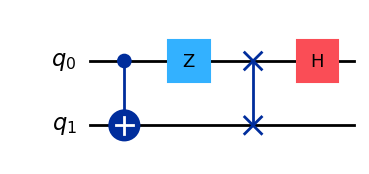

In [13]:
# X
with QiskitTester(2) as QT:
    QT.circuit.cx(QT.q(1), QT.q(0))
    QT.circuit.z(QT.q(1))
    QT.circuit.swap(QT.q(0),QT.q(1))
    QT.circuit.h(QT.q(1))
QT.circuit.draw("mpl")

In [33]:
(np.array(Operator(QT.circuit).data)*np.sqrt(2)).round(2).real.T

array([[ 1.,  1.,  0.,  0.],
       [ 0.,  0., -1.,  1.],
       [ 1., -1.,  0.,  0.],
       [ 0.,  0., -1., -1.]])

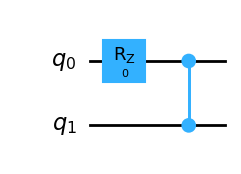

In [10]:
# GATE 1
with QiskitTester(2) as QT:
    QT.circuit.rz(0,QT.q(1))
    QT.circuit.cz(QT.q(0),QT.q(1))
QT.circuit.draw("mpl")

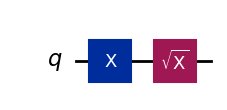

In [12]:
# GATE 2
with QiskitTester(1) as QT:
    QT.circuit.x(QT.q(0))
    QT.circuit.sx(QT.q(0))
QT.circuit.draw("mpl")

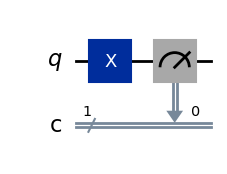

In [14]:
circuit = QuantumCircuit(1, 1)
circuit.x(0)
circuit.measure(0, 0)
circuit.draw("mpl")